In [1]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# WatChMaL imports
from io_utils.data_handling_2 import WCH5Dataset

# PyTorch imports
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter 

In [2]:
path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions', 'root_files']>

### Plot the histogram of the two observables
    1. Sum of charges in an event
    2. Number of PMTs hit

### 1. Sum of charges in an event

In [3]:
train_batch_size = 1024
dset=WCH5Dataset(path, 0.1, 0.1, reduced_dataset_size=300000)

train_loader = DataLoader(dset, batch_size=train_batch_size, shuffle=False,
                          num_workers=4, sampler=SubsetRandomSampler(dset.train_indices))

In [4]:
event_charges = []
event_timings = []

labels = []
energies = []

for data in iter(train_loader):
    event_charges.append(data[0][:,:,:,:19].numpy())
    event_timings.append(data[0][:,:,:,19:].numpy())
    
    labels.append(data[1].numpy())
    energies.append(data[2].numpy())

In [5]:
print(len(event_charges), event_charges[0].shape, len(event_timings), event_timings[0].shape)
print(len(labels), labels[0].shape, len(energies), energies[0].shape)

235 (1024, 40, 40, 19) 235 (1024, 40, 40, 19)
235 (1024,) 235 (1024, 1)


In [6]:
event_charges = np.concatenate(event_charges, axis=0)
event_timings = np.concatenate(event_timings, axis=0)

In [7]:
labels = np.concatenate(labels, axis=0)
energies = np.concatenate(energies, axis=0)

In [8]:
print(event_charges.shape, event_timings.shape, labels.shape, energies.shape)

(240000, 40, 40, 19) (240000, 40, 40, 19) (240000,) (240000, 1)


### Reshape the energy and labels np arrays

In [9]:
labels = labels.reshape(-1)
energies = energies.reshape(-1)

### Distrbution of the labels

In [10]:
print(Counter(labels))

Counter({0: 80930, 1: 79829, 2: 79241})


### Select the events based on the energy

In [ ]:
min_energy = 40
max_energy = 50

In [ ]:
energies_mask = np.logical_and(energies >= min_energy, energies <= max_energy)
energies_mask = energies_mask.reshape(energies_mask.shape[0])

In [ ]:
print(energies_mask.shape)

In [ ]:
local_event_charges = event_charges[energies_mask]
local_event_timings = event_timings[energies_mask]
local_labels        = labels[energies_mask].reshape(-1)
local_energies      = energies[energies_mask]

In [ ]:
print(Counter(local_labels))

In [ ]:
sum_event_charges = np.sum(local_event_charges.reshape(local_event_charges.shape[0], -1), axis=1)
sum_event_timings = np.sum(local_event_timings.reshape(local_event_timings.shape[0], -1), axis=1)

In [ ]:
local_event_charges.reshape(local_event_charges.shape[0], -1).shape

In [ ]:
print(sum_event_charges.shape, sum_event_timings.shape, local_labels.shape)

### Plot the per event sum charge distribution

In [17]:
label_dict = {0:["gamma", "red"], 1:["e", "blue"], 2:["mu", "green"]}

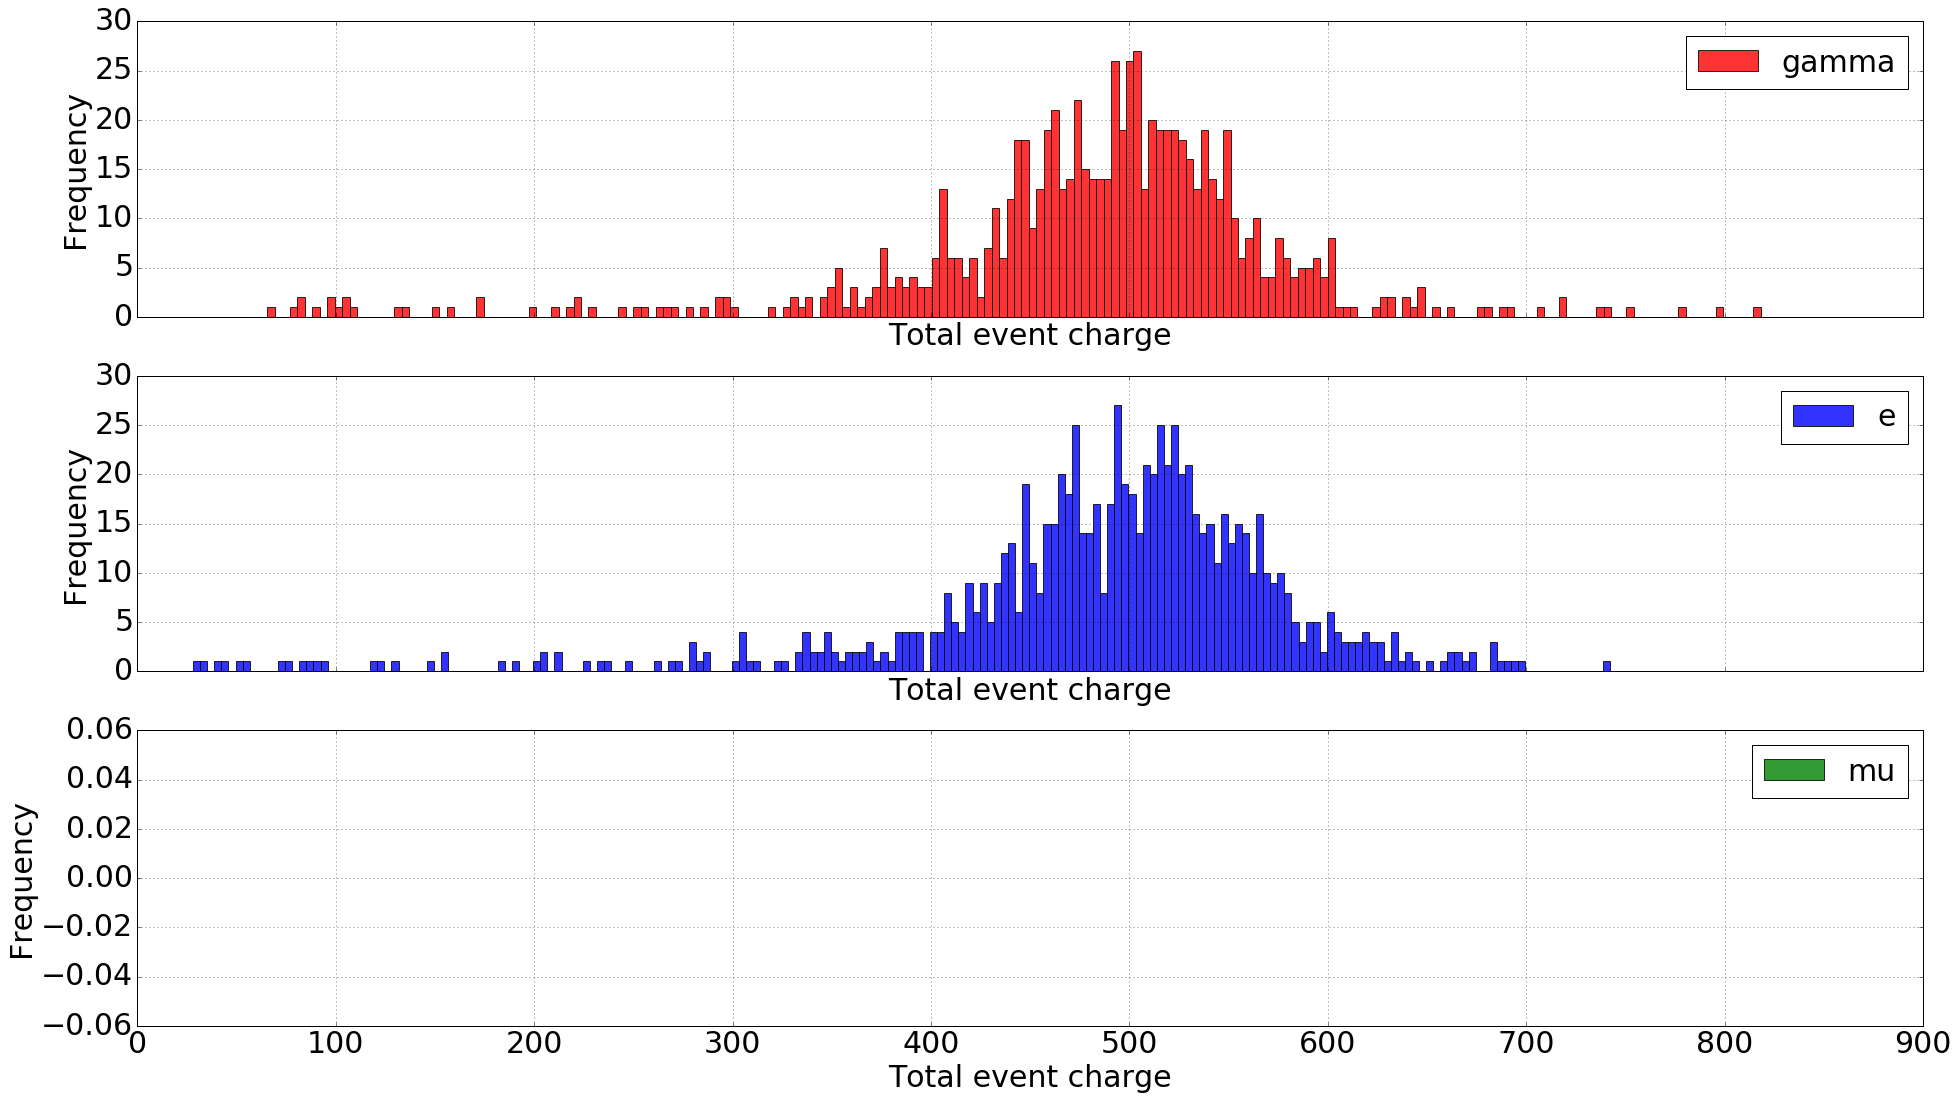

In [20]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = sum_event_charges[local_labels == label]
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("Total event charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")

### Place a cut on the total observed event charge and plot the energy effciency

In [11]:
print(event_charges.shape, event_timings.shape, labels.shape, energies.shape)

(240000, 40, 40, 19) (240000, 40, 40, 19) (240000,) (240000,)


In [12]:
sum_global_event_charges = np.sum(event_charges.reshape(event_charges.shape[0], -1), axis=1)
sum_global_event_timings = np.sum(event_timings.reshape(event_timings.shape[0], -1), axis=1)

In [13]:
print(sum_global_event_charges.shape, sum_global_event_timings.shape)

(240000,) (240000,)


### Placing a cut at 500 p.e.

In [38]:
min_charge = 500

charges_mask = sum_global_event_charges >= min_charge
charges_mask = charges_mask.reshape(charges_mask.shape[0])

In [39]:
select_labels   = labels[charges_mask]
select_energies = energies[charges_mask]

print(select_labels.shape, select_energies.shape)

(219505,) (219505,)


### Plot the original energy distribution

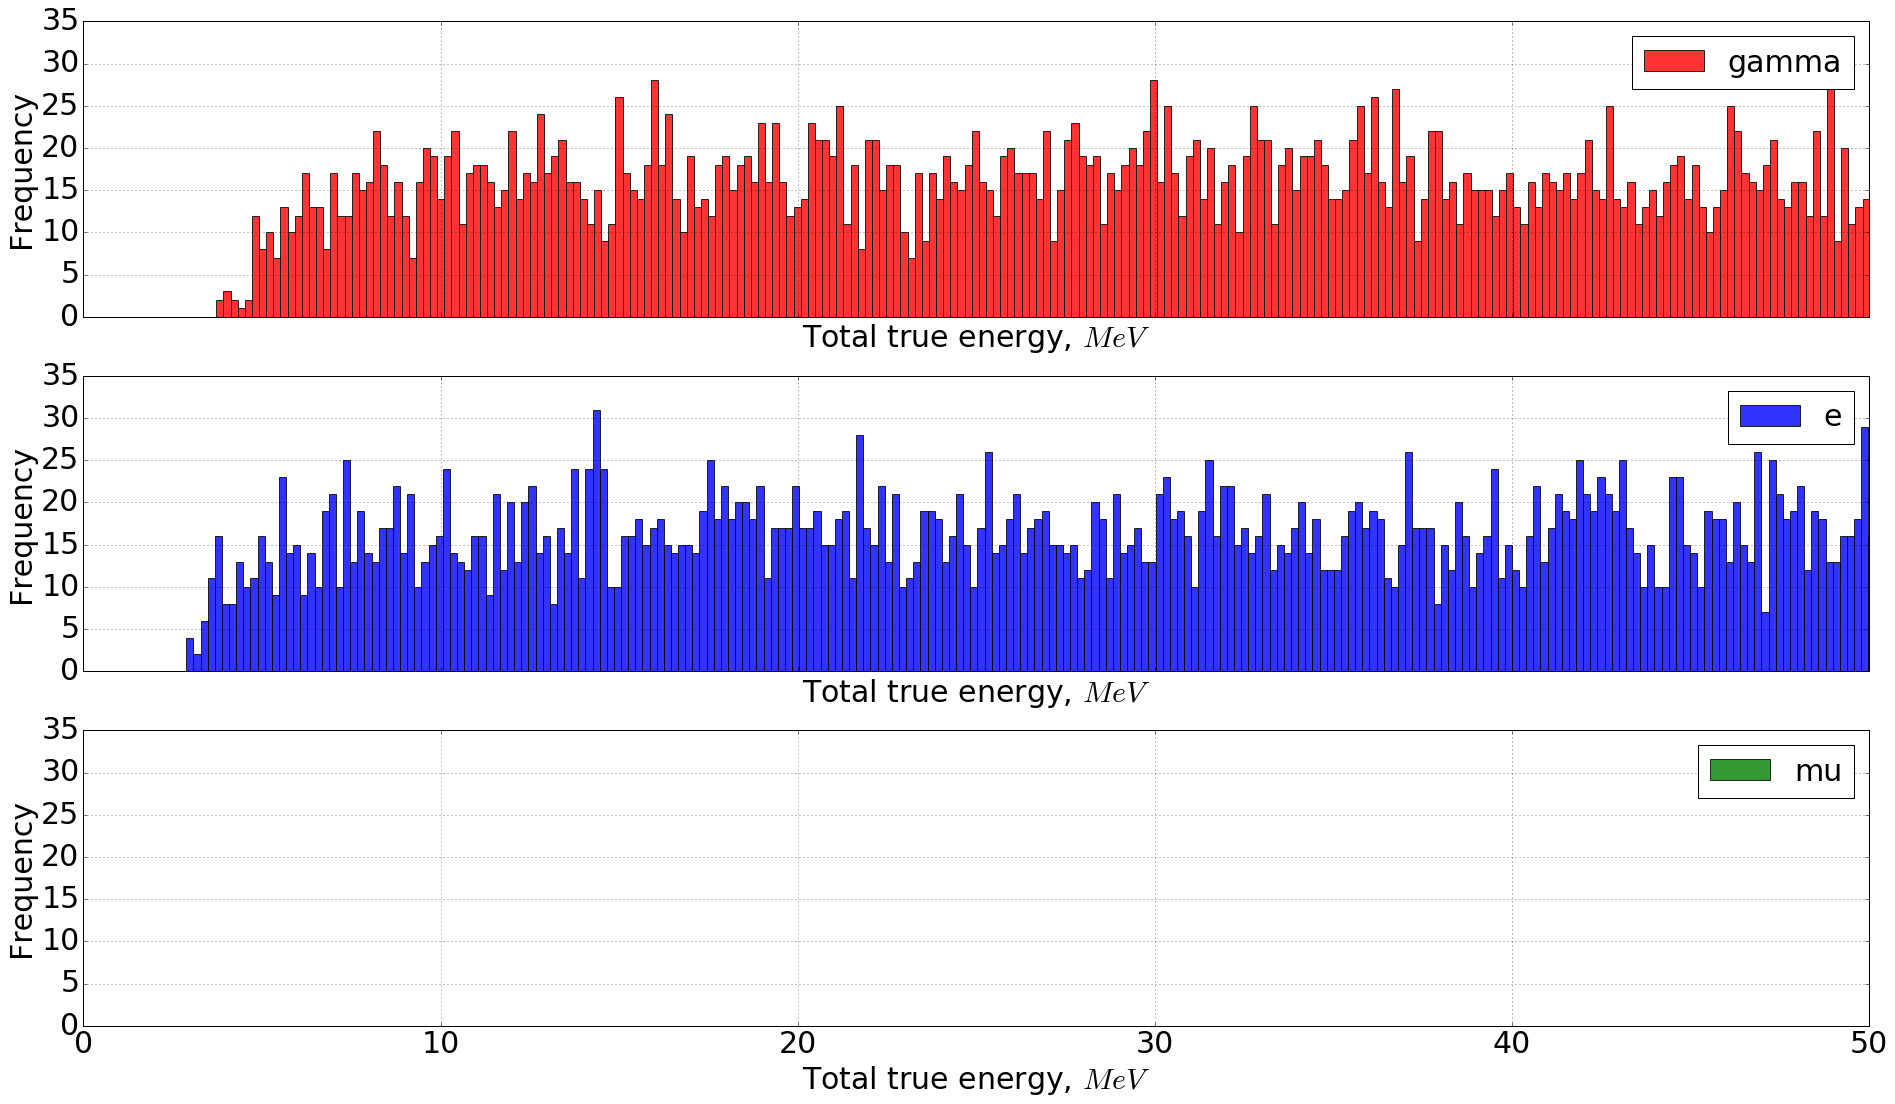

In [27]:
energy_dict = {}
for label in label_dict.keys():
    energy_dict[label] = energies[labels == label]
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(energy_dict[label], bins=5000, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"Total true energy, $MeV$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_xlim(0, 50)

### Plot the resulting energy distribution

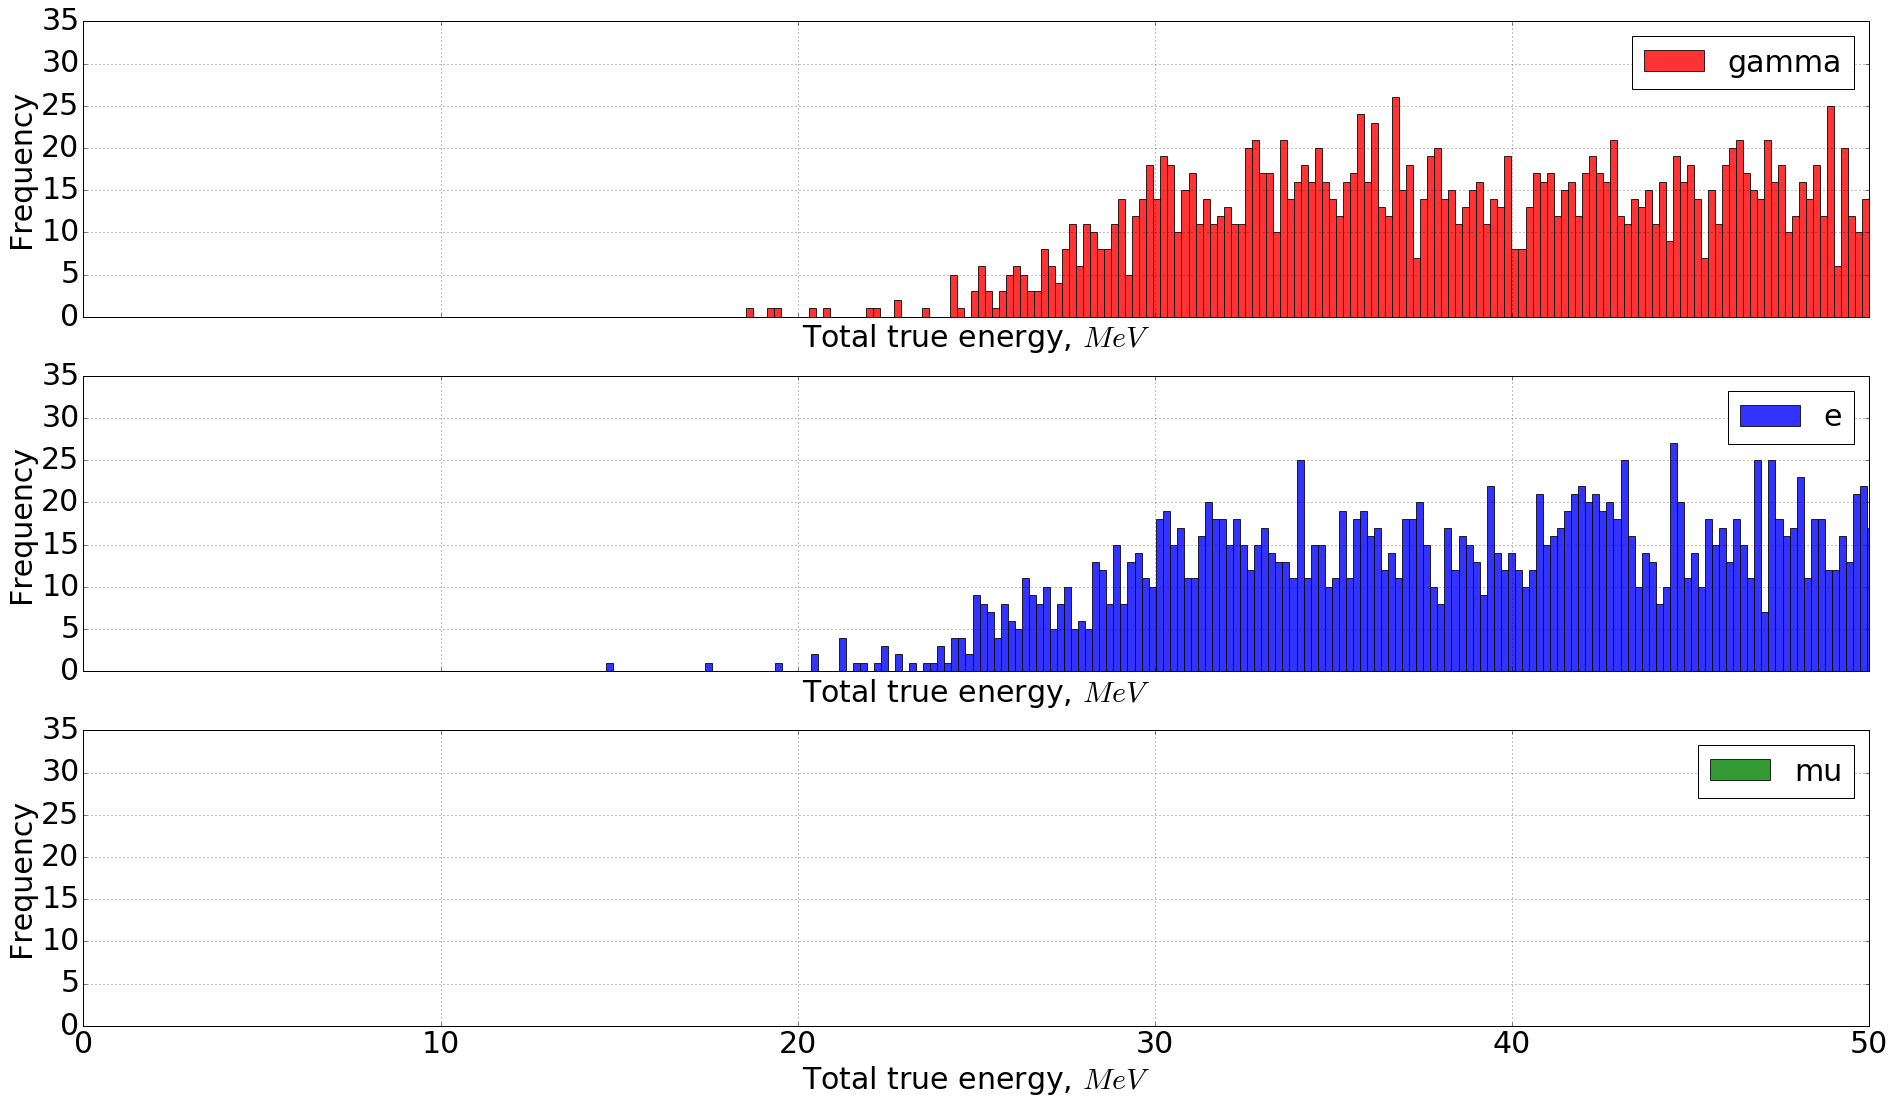

In [28]:
energy_dict = {}
for label in label_dict.keys():
    energy_dict[label] = select_energies[select_labels == label]
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(energy_dict[label], bins=5000, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"Total true energy, $MeV$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_xlim(0, 50)

### Plot the efficiency at different energy intervals

In [40]:
energy_dict = {}
select_energy_dict = {}
for label in label_dict.keys():
    energy_dict[label] = energies[labels == label]
    select_energy_dict[label] = select_energies[select_labels == label]

num_bins = 5001
min_energy = min(np.amin(energies), np.amin(select_energies))
max_energy = max(np.amax(energies), np.amax(select_energies))

bins = np.arange(min_energy, max_energy, (max_energy-min_energy)/num_bins)

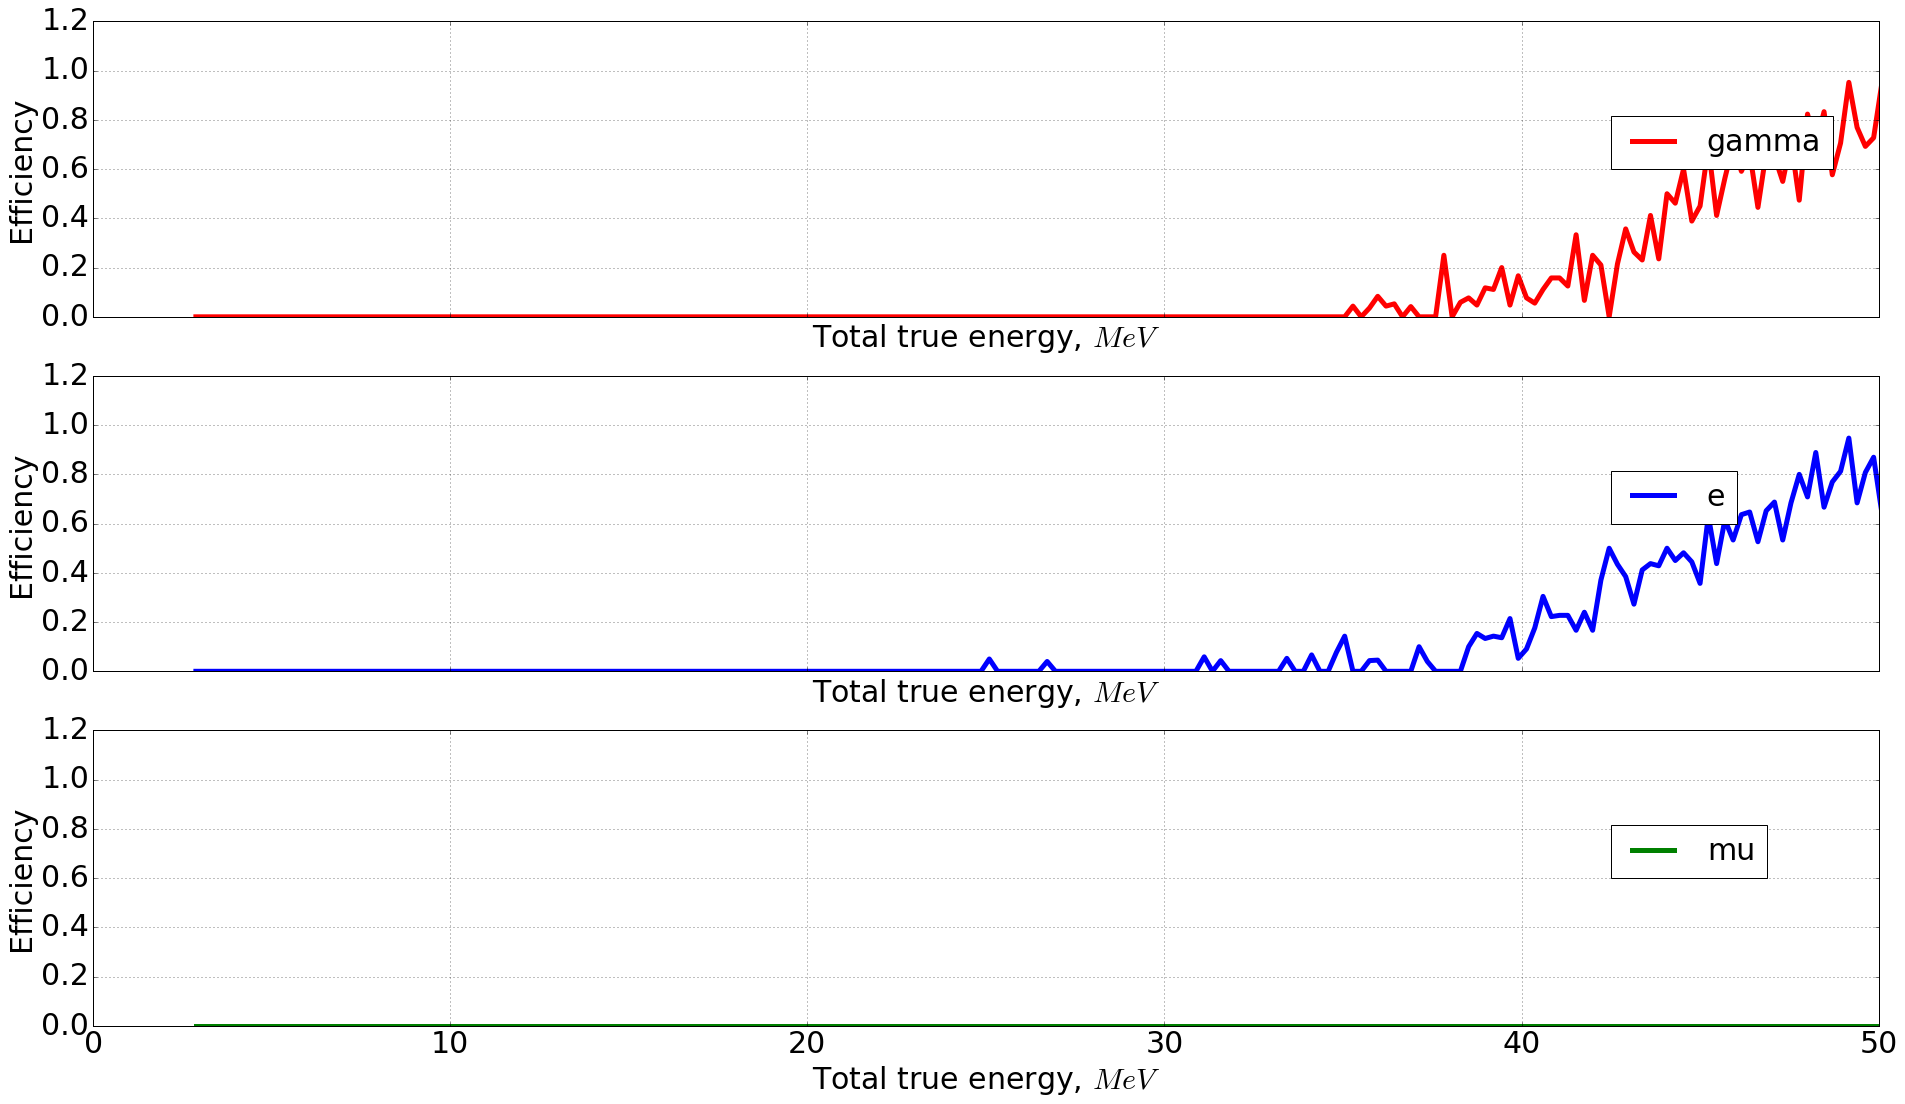

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    values, _       = np.histogram(energy_dict[label], bins=bins)
    select_values, _ = np.histogram(select_energy_dict[label], bins=bins)
    
    ratio = []
    for value, select_value in zip(values, select_values):
        curr_ratio = select_value/value if value != 0 else 0
        ratio.append(curr_ratio)
        
    axes[label].plot(bins[:-1], ratio, label=label_dict[label][0], alpha=1.0, color=label_dict[label][1],
                     fillstyle="full", linewidth=5.0)
    axes[label].legend(prop={"size":30}, loc={0.85, 0.5})
    axes[label].set_xlabel(r"Total true energy, $MeV$", fontsize=30)
    axes[label].set_ylabel("Efficiency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_ylim(0, 1.2)
    axes[label].set_xlim(0, 50)